In [20]:
#import all required packages
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np 
from PIL import Image
from tqdm import tqdm_notebook

from sklearn.utils import shuffle
from resnets_utils import *

import imageio
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from keras.models import model_from_json
from keras.optimizers import SGD, Adam

%matplotlib inline

In [21]:
#Initialize paths related to training and testing datasets
print("Base directory:        %s" % os.getcwd())

path =  '.'
train_folder = os.path.join(path, 'train_images')
test_folder =  os.path.join(path,  'leaderboard_test_data')
holdout_folder = os.path.join(path,  'leaderboard_holdout_data')
sample_sub = os.path.join(path, 'SampleSubmission.csv')
labels = os.path.join(path,  'traininglabels.csv')

print("Training images path:  %s " % train_folder)
print("Test images path:      %s " % test_folder)
print("Holdout images path:   %s " % holdout_folder)
print("Sample submission:     %s " % sample_sub)
print("Training Labels path:  %s " % labels)



Base directory:        D:\deep_udacity\deep-learning\kaggle\widsdatathon2019
Training images path:  .\train_images 
Test images path:      .\leaderboard_test_data 
Holdout images path:   .\leaderboard_holdout_data 
Sample submission:     .\SampleSubmission.csv 
Training Labels path:  .\traininglabels.csv 


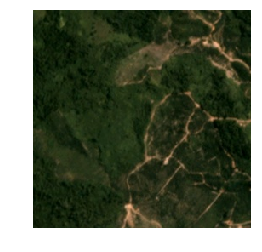

In [22]:
pixel_depth=256

#Display sample training image
image_file = os.path.join( train_folder , "img_000002017.jpg")
image_data = (  imageio.imread(image_file).astype(float)) / pixel_depth
 
plt.axis('off')
plt.imshow(image_data )

#image data has 3 layers. We can also display each layer separately.
# for i in range(3):
#     result = image_data[:, :, i]
#     #newarray = np.delete(image_data, [0,1,2], 2)
#     print(str(result.shape))
 
#     plt.figure()
#     plt.imshow(result)  # di

In [23]:
#Read labels for training set and sample submission
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

df_has_oilpalm = df[ (df['has_oilpalm']==1) & (df['score']>0.5) ]
df_has_no_oilpalm = df[ (df['has_oilpalm']==0) & (df['score'] == 1) ].sample(n=len(df_has_oilpalm), random_state=1)

df_train_sample = pd.concat([ df_has_oilpalm, df_has_no_oilpalm ])
df_train_x = df_train_sample.sample(frac=0.8, random_state=3)
df_valid_x = df_train_sample.loc[~df_train_sample.index.isin(df_train_x.index)]
 
print("Has oil palm ", len(df_has_oilpalm)) 
print("Has No oil palm ", len(df_has_no_oilpalm)) 
print("Total Training data ", len(df_train_sample)) 
print("Total training data ", len(df_train_x)) 
print("Total validation data ", len(df_valid_x))

Has oil palm  920
Has No oil palm  920
Total Training data  1840
Total training data  1472
Total validation data  368


In [24]:
#Read images defined in dataframe to image array
image_size=256
image_layers=3

#Method to load training images mentioned in df
def load_training_images(df):
    
    loaded_images = np.ndarray(shape=(len(df), image_size, image_size,image_layers), dtype=np.float32)

    num_images = 0

    for index, row in df.iterrows():
        image_name = row["image_id"]
        image_file = os.path.join(train_folder, image_name)
        try:
          image_data = (imageio.imread(image_file).astype(float) ) / pixel_depth
          loaded_images[num_images, :, :,:] = image_data
          num_images = num_images + 1
        except (IOError, ValueError) as e:
          print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    #If we could not read any image, resize the array to correct length
    loaded_images = loaded_images[0:num_images, :, :,:]

    return loaded_images


#Method to load images available in a folder
def load_images_from_folder(folder_name):
    
    image_files = os.listdir(folder_name)
        
    loaded_images = np.ndarray(shape=(len(image_files), image_size, image_size,image_layers), dtype=np.float32)

    num_images = 0

    for image_name in image_files:
 
        image_file = os.path.join(folder_name, image_name)
        try:
          image_data = (imageio.imread(image_file).astype(float) ) / pixel_depth
          loaded_images[num_images, :, :,:] = image_data
          num_images = num_images + 1
        except (IOError, ValueError) as e:
          print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    #If we could not read any image, resize the array to correct length
    loaded_images = loaded_images[0:num_images, :, :,:]
 
    return loaded_images
    
training_images = load_training_images(df_train_x)
validation_images = load_training_images(df_valid_x)
# test_images = load_images_from_folder( os.path.join(path,  'ltd'))
training_labels = df_train_x.iloc[:,1:2].values
training_labels = training_labels.T

validation_labels = df_valid_x.iloc[:,1:2].values
validation_labels = validation_labels.T

classes = np.asarray([0,1], dtype = float) 
 
print('Train images shape: ', training_images.shape)
print('Traing labels shape: ', training_labels.shape)

print('Validation images shape: ', validation_images.shape)
print('Validation labels shape: ', validation_labels.shape)


print('Classes shape: ', classes.shape)
# print('Test images shape: ', test_images.shape)
  

Train images shape:  (1472, 256, 256, 3)
Traing labels shape:  (1, 1472)
Validation images shape:  (368, 256, 256, 3)
Validation labels shape:  (1, 368)
Classes shape:  (2,)


In [ ]:
#Pickle images into a file so that we don't have to repeat in case of crash.
def pickle_data(name, data ):
  filename = name + '.pickle'
  print('Pickling %s.' % filename)
  try:
    with open(filename, 'wb') as f:
      pickle.dump(data, f, protocol=2)
  except Exception as e:
      print('Unable to save data to', filename, ':', e)
  print("Save complete")
  


# pickle_data("training_images_1", training_images[1:300])
# pickle_data("training_images_2", training_images[301:600])

pickle_data("training_images_3", training_images[601:])

# pickle_data("validation_images", validation_images)

# pickle_data("training_labels", training_labels)
# pickle_data("validation_labels", validation_labels)

# pickle_data("classes", classes)

In [ ]:
#UnPickle images from a file just to ensure we did not mess during pickling
def unpickle_data( filename ):
  
  print('Unpickling %s.' % filename)
 
  try:
    with open(filename, 'rb') as f:
      data = pickle.load(f)  # unpickle  
  except Exception as e:
      print('Unable to load data from ', filename, ':', e)
  print("Load complete")
  return data


train_images = unpickle_data("train_images.pickle")
test_images = unpickle_data("test_images.pickle" )
train_labels = unpickle_data("train_labels.pickle" )
classes = unpickle_data("classes.pickle" )
  
print('Train images shape: ', train_images.shape)
print('Traing labels shape: ', train_labels.shape)
print('Classes shape: ', classes.shape)
print('Test images shape: ', test_images.shape)
#Di  

In [ ]:
#Display an image from pickle to ensure we are good with pickling and unpickling
with open("train_images.pickle", 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :,]  # extract a 2D slice
    #print(sample_image)
    plt.figure()
    plt.imshow(sample_image)  # display it

In [ ]:
#Just making sure we are good with unpickling
from IPython.display import display, Image
sample_image=training_images[0]
plt.figure()
plt.imshow(sample_image)  # di

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
    
X_train_orig=X_train_orig[1:50]
 
Y_train_orig = np.delete(Y_train_orig, np.s_[49:], 1)

print(str(Y_train_orig.shape))


In [25]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# print(train_labels.shape)
y_train = convert_to_one_hot(training_labels, 2).T
# print ("Y_train shape: " + str(y_train.shape))
# print(train_labels)
# print( y_train)
x_train = training_images

print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))



X_train shape: (1472, 256, 256, 3)
Y_train shape: (1472, 2)


In [26]:
img_height,img_width = 64,64 
img_height,img_width = 256,256 
num_classes = 2
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

D:\Anaconda2\envs\ipykernel_py3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [28]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
model.fit(x_train, y_train, epochs = 1, batch_size = 16,verbose=1)

Epoch 1/1
1472/1472 [==============================] - ETA: 1:51:07 - loss: 1.3969 - acc: 0.43 - ETA: 1:33:05 - loss: 1.4207 - acc: 0.43 - ETA: 1:25:01 - loss: 1.3573 - acc: 0.47 - ETA: 1:23:17 - loss: 1.4265 - acc: 0.46 - ETA: 1:24:42 - loss: 1.3068 - acc: 0.51 - ETA: 1:24:58 - loss: 1.2815 - acc: 0.50 - ETA: 1:23:42 - loss: 1.3016 - acc: 0.51 - ETA: 1:21:39 - loss: 1.2139 - acc: 0.53 - ETA: 1:19:01 - loss: 1.1267 - acc: 0.56 - ETA: 1:18:00 - loss: 1.1848 - acc: 0.55 - ETA: 1:16:30 - loss: 1.1411 - acc: 0.56 - ETA: 1:14:48 - loss: 1.0979 - acc: 0.57 - ETA: 1:13:48 - loss: 1.0984 - acc: 0.57 - ETA: 1:12:25 - loss: 1.1559 - acc: 0.56 - ETA: 1:10:55 - loss: 1.1374 - acc: 0.57 - ETA: 1:09:37 - loss: 1.1316 - acc: 0.57 - ETA: 1:08:15 - loss: 1.1171 - acc: 0.57 - ETA: 1:06:58 - loss: 1.0896 - acc: 0.59 - ETA: 1:05:46 - loss: 1.1336 - acc: 0.58 - ETA: 1:04:35 - loss: 1.1125 - acc: 0.59 - ETA: 1:03:23 - loss: 1.1122 - acc: 0.58 - ETA: 1:02:50 - loss: 1.1083 - acc: 0.59 - ETA: 1:02:02 - loss: 

In [30]:
model_json = model.to_json()

In [31]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 

Loaded model from disk


In [33]:
adam = Adam(lr=0.0001)
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
y_validation = convert_to_one_hot(validation_labels, 2).T

In [48]:
preds = loaded_model.evaluate(validation_images, y_validation)

368/368 [==============================] - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 37s - ETA: 12 - 288s 783ms/step


In [49]:
print ("Loss = " + str(preds[0]))

print ("Test Accuracy = " + str(preds[1]))

Loss = 1.2924525349036506
Test Accuracy = 0.7907608695652174


In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_59 (Activation)      (None, 64, 64, 256)  0           add_19[0][0]                     
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 32, 32, 128)  32896       activation_59[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 32, 32, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 32, 32, 128)  147584      activation_60[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 32, 32, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_23 (Add)                    (None, 32, 32, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_68[0][0]              
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 32, 32, 512)  0           add_23[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_71[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 16, 16, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 16, 16, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 16, 16, 1024) 263168      activation_82[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 16, 16, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_27 (Add)                    (None, 16, 16, 1024) 0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_93 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_93[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________